I am going to import the necessary and important libraries for my notebook

## Importing the libraries and preparing the data

In [0]:
# Import Libraries necessary for the streaming
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, DoubleType
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as random
import time

It is important to name the spark session for different applications (appname)

In [0]:
# Initialize Spark Session
spark = SparkSession.builder.appName("Streaming Iris Clustering - Big Data Analytics").getOrCreate()

### Defining the schema of our streaming data (what goes inside each record)
It is important to write the types of each column (even the target) in our dataframe. 

In [0]:
# Define schema for the streaming data
schema = StructType([
    StructField("sepal_length", DoubleType(), True),
    StructField("sepal_width", DoubleType(), True),
    StructField("petal_length", DoubleType(), True),
    StructField("petal_width", DoubleType(), True)
])

### Important: Download the dataset to a temporary folder (will destroy after closing the application)
We define the dataset through an urlib request this time (different from previous times where we uploaded the file to the dbfs/FileStore)

In [0]:
# Download dataset to /tmp/
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
save_path = "/tmp/iris.csv"
urllib.request.urlretrieve(url, save_path)
print(f"Downloaded dataset to {save_path}")

Downloaded dataset to /tmp/iris.csv


In [0]:

display(dbutils.fs.ls("dbfs:/FileStore/tables/copy_notebook-1.png"))


[FileInfo(path='dbfs:/FileStore/tables/copy_notebook-1.png', name='copy_notebook-1.png', size=151992, modificationTime=1742154813000)]

### Create a file directory (folder) to have our data (our streaming data)
Copy from temp directory to a dbfs directory
![Image](https://community.cloud.databricks.com/files/tables/copy_notebook-2.png)


In [0]:
# Copy file to DBFS
dbutils.fs.mkdirs("dbfs:/mnt/data/streaming_iris")
dbutils.fs.cp("file:/tmp/iris.csv", "dbfs:/mnt/data/streaming_iris/iris.csv")

Out[91]: True

In [0]:
# Define streaming data source
streaming_df = spark.readStream.format("csv") \
    .option("header", "false") \
    .schema(schema) \
    .load("dbfs:/mnt/data/streaming_iris/")

## Machine Learning: Clustering
In this part of the code you will define the estimator and the transformers that you will use to do clustering on the data. 


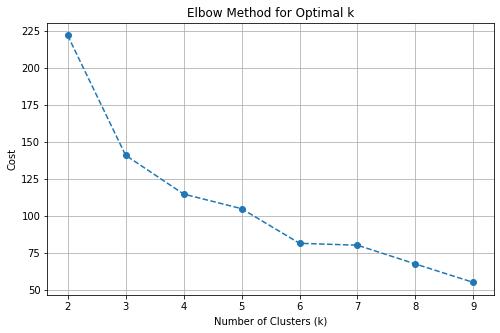

In [0]:
# Select features for clustering
feature_cols = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="raw_features")

# Read static data for model training
static_df = spark.read.format("csv").option("header", "false").schema(schema).load("dbfs:/mnt/data/streaming_iris/iris.csv")
static_features = assembler.transform(static_df)

# Standardize features
scaler = StandardScaler(inputCol="raw_features", outputCol="features", withStd=True, withMean=True)
scaler_model = scaler.fit(static_features)
static_scaled = scaler_model.transform(static_features).select(*feature_cols, "features")

# **Elbow Method to Determine Optimal k**
cost = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(k=k, seed=1, featuresCol="features")
    model = kmeans.fit(static_scaled)
    cost.append(model.summary.trainingCost)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(k_range, cost, marker="o", linestyle="--")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Cost")
plt.title("Elbow Method for Optimal k")
plt.grid()
plt.show()

In [0]:
# Save Elbow Method plot to DBFS
elbow_plot_path = "dbfs:/mnt/data/plots/elbow_method.png"
plt.savefig("/tmp/elbow_method.png")
dbutils.fs.cp("file:/tmp/elbow_method.png", elbow_plot_path)
plt.close()
print(f"Elbow method plot saved at {elbow_plot_path}")

Elbow method plot saved at dbfs:/mnt/data/plots/elbow_method.png


### First Task: Dynamically define the best K

Help: https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

In [0]:
#### **Train KMeans with optimal k (assumed 3 from Elbow Method)**
optimal_k = 3  # TODO: Ideally, choose this dynamically based on the elbow method
kmeans = KMeans(k=optimal_k, seed=1, featuresCol="features")
kmeans_model = kmeans.fit(static_scaled)

In [0]:
# Prepare streaming data
df_features = assembler.transform(streaming_df)
df_scaled = scaler_model.transform(df_features).select(*feature_cols, "features")
df_clustered = kmeans_model.transform(df_scaled).select(*feature_cols, "prediction")

Checking for new data - Iteration 1
Appended new data to dbfs:/mnt/data/streaming_iris/new_iris35.csv
     sepal_length  sepal_width  petal_length  petal_width  prediction
0             5.1          3.5           1.4          0.2           5
1             4.9          3.0           1.4          0.2           4
2             4.7          3.2           1.3          0.2           4
3             4.6          3.1           1.5          0.2           4
4             5.0          3.6           1.4          0.2           5
..            ...          ...           ...          ...         ...
445           6.7          3.0           5.2          2.3           3
446           6.3          2.5           5.0          1.9           7
447           6.5          3.0           5.2          2.0           3
448           6.2          3.4           5.4          2.3           3
449           5.9          3.0           5.1          1.8           3

[450 rows x 5 columns]


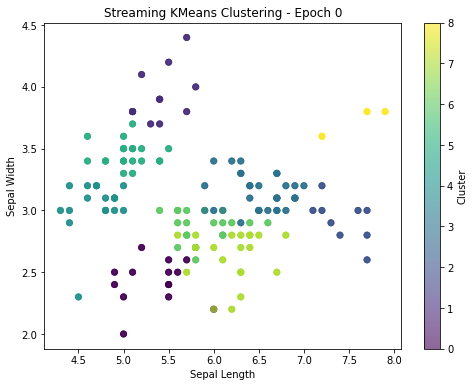

Saved plot: dbfs:/mnt/data/plots/plot_epoch_0.png


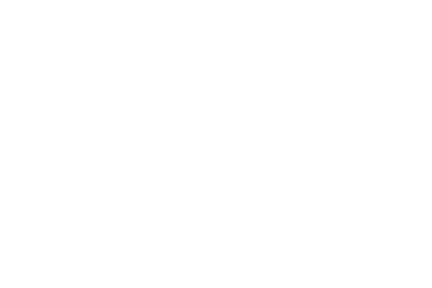

+------------+-----------+------------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|
+------------+-----------+------------+-----------+
|         5.1|        3.5|         1.4|        0.2|
|         4.9|        3.0|         1.4|        0.2|
|         4.7|        3.2|         1.3|        0.2|
|         4.6|        3.1|         1.5|        0.2|
|         5.0|        3.6|         1.4|        0.2|
|         5.4|        3.9|         1.7|        0.4|
|         4.6|        3.4|         1.4|        0.3|
|         5.0|        3.4|         1.5|        0.2|
|         4.4|        2.9|         1.4|        0.2|
|         4.9|        3.1|         1.5|        0.1|
|         5.4|        3.7|         1.5|        0.2|
|         4.8|        3.4|         1.6|        0.2|
|         4.8|        3.0|         1.4|        0.1|
|         4.3|        3.0|         1.1|        0.1|
|         5.8|        4.0|         1.2|        0.2|
|         5.7|        4.4|         1.5|        0.4|
|         5.

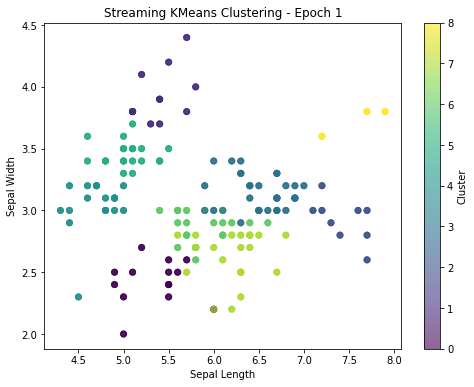

Saved plot: dbfs:/mnt/data/plots/plot_epoch_1.png


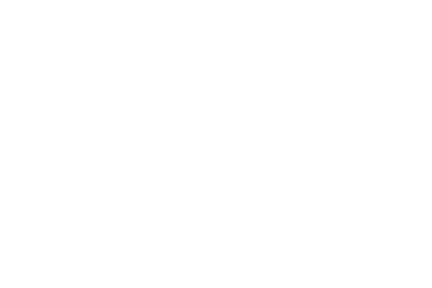

+------------+-----------+------------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|
+------------+-----------+------------+-----------+
|         5.1|        3.5|         1.4|        0.2|
|         4.9|        3.0|         1.4|        0.2|
|         4.7|        3.2|         1.3|        0.2|
|         4.6|        3.1|         1.5|        0.2|
|         5.0|        3.6|         1.4|        0.2|
|         5.4|        3.9|         1.7|        0.4|
|         4.6|        3.4|         1.4|        0.3|
|         5.0|        3.4|         1.5|        0.2|
|         4.4|        2.9|         1.4|        0.2|
|         4.9|        3.1|         1.5|        0.1|
|         5.4|        3.7|         1.5|        0.2|
|         4.8|        3.4|         1.6|        0.2|
|         4.8|        3.0|         1.4|        0.1|
|         4.3|        3.0|         1.1|        0.1|
|         5.8|        4.0|         1.2|        0.2|
|         5.7|        4.4|         1.5|        0.4|
|         5.

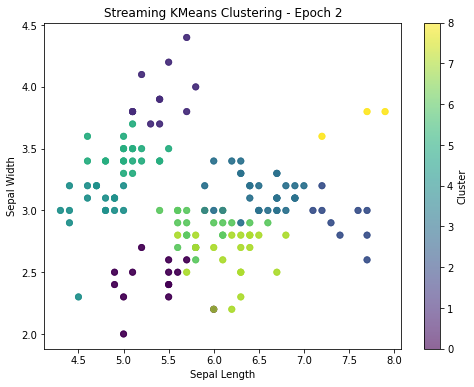

Saved plot: dbfs:/mnt/data/plots/plot_epoch_2.png


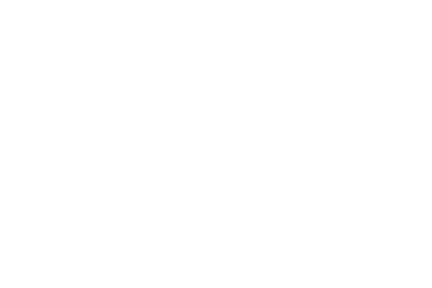

+------------+-----------+------------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|
+------------+-----------+------------+-----------+
|         5.1|        3.5|         1.4|        0.2|
|         4.9|        3.0|         1.4|        0.2|
|         4.7|        3.2|         1.3|        0.2|
|         4.6|        3.1|         1.5|        0.2|
|         5.0|        3.6|         1.4|        0.2|
|         5.4|        3.9|         1.7|        0.4|
|         4.6|        3.4|         1.4|        0.3|
|         5.0|        3.4|         1.5|        0.2|
|         4.4|        2.9|         1.4|        0.2|
|         4.9|        3.1|         1.5|        0.1|
|         5.4|        3.7|         1.5|        0.2|
|         4.8|        3.4|         1.6|        0.2|
|         4.8|        3.0|         1.4|        0.1|
|         4.3|        3.0|         1.1|        0.1|
|         5.8|        4.0|         1.2|        0.2|
|         5.7|        4.4|         1.5|        0.4|
|         5.

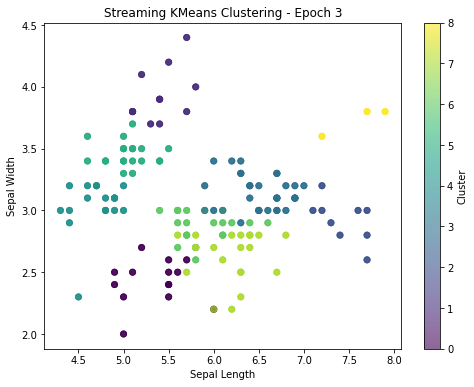

Saved plot: dbfs:/mnt/data/plots/plot_epoch_3.png


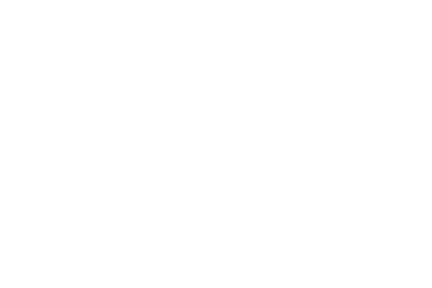

+------------+-----------+------------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|
+------------+-----------+------------+-----------+
|         5.1|        3.5|         1.4|        0.2|
|         4.9|        3.0|         1.4|        0.2|
|         4.7|        3.2|         1.3|        0.2|
|         4.6|        3.1|         1.5|        0.2|
|         5.0|        3.6|         1.4|        0.2|
|         5.4|        3.9|         1.7|        0.4|
|         4.6|        3.4|         1.4|        0.3|
|         5.0|        3.4|         1.5|        0.2|
|         4.4|        2.9|         1.4|        0.2|
|         4.9|        3.1|         1.5|        0.1|
|         5.4|        3.7|         1.5|        0.2|
|         4.8|        3.4|         1.6|        0.2|
|         4.8|        3.0|         1.4|        0.1|
|         4.3|        3.0|         1.1|        0.1|
|         5.8|        4.0|         1.2|        0.2|
|         5.7|        4.4|         1.5|        0.4|
|         5.

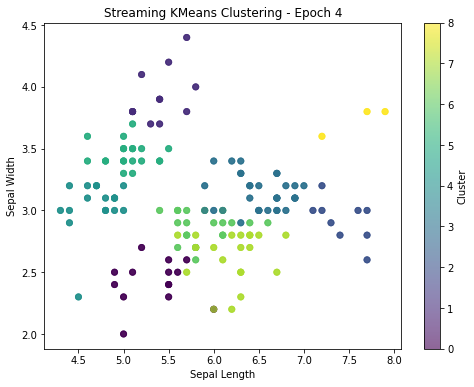

Saved plot: dbfs:/mnt/data/plots/plot_epoch_4.png


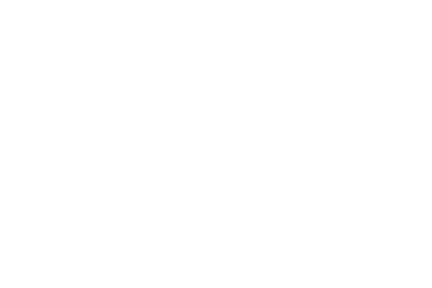

+------------+-----------+------------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|
+------------+-----------+------------+-----------+
|         5.1|        3.5|         1.4|        0.2|
|         4.9|        3.0|         1.4|        0.2|
|         4.7|        3.2|         1.3|        0.2|
|         4.6|        3.1|         1.5|        0.2|
|         5.0|        3.6|         1.4|        0.2|
|         5.4|        3.9|         1.7|        0.4|
|         4.6|        3.4|         1.4|        0.3|
|         5.0|        3.4|         1.5|        0.2|
|         4.4|        2.9|         1.4|        0.2|
|         4.9|        3.1|         1.5|        0.1|
|         5.4|        3.7|         1.5|        0.2|
|         4.8|        3.4|         1.6|        0.2|
|         4.8|        3.0|         1.4|        0.1|
|         4.3|        3.0|         1.1|        0.1|
|         5.8|        4.0|         1.2|        0.2|
|         5.7|        4.4|         1.5|        0.4|
|         5.

In [0]:

from IPython.display import display
from PIL import Image



# **Function to plot streaming clusters** [TODO: Put it to work]
def plot_clusters(batch_df, epoch_id):
    if batch_df.count() > 0:

        # Feature Engineering
        static_features = assembler.transform(batch_df)

        # Standardization
        scaler_model = scaler.fit(static_features)
        static_scaled = scaler_model.transform(static_features).select(*feature_cols, "features")

        # Apply model to assign clusters
        df_clustered = model.transform(static_scaled)

        

        # Convert to Pandas
        pdf = df_clustered.select(*feature_cols, "prediction").toPandas()

        print(pdf)
        plt.figure(figsize=(8, 6))
        plt.scatter(pdf["sepal_length"], pdf["sepal_width"], c=pdf["prediction"], cmap="viridis", alpha=0.6)
        plt.xlabel("Sepal Length")
        plt.ylabel("Sepal Width")
        plt.title(f"Streaming KMeans Clustering - Epoch {epoch_id}")
        plt.colorbar(label="Cluster")
        plt.show()

        # Save plot to DBFS
        plot_path = f"dbfs:/mnt/data/plots/plot_epoch_{epoch_id}.png"
        plt.savefig(f"/tmp/plot_epoch_{epoch_id}.png")
        dbutils.fs.cp(f"file:/tmp/plot_epoch_{epoch_id}.png", plot_path)
        plt.close()

        print(f"Saved plot: {plot_path}")

        # Display the image in Databricks
        # Display the image using IPython
        image = Image.open(f"/tmp/plot_epoch_{epoch_id}.png")
        display(image)

        

# **Simulate streaming by appending new data** [TODO: Try to create new files with just one line at a time to stream line by line]
def append_new_data():
    iris_df = pd.read_csv(save_path, header=None)
    iris_df.columns = ["sepal_length", "sepal_width", "petal_length", "petal_width", "class"]
    iris_df.drop("class", axis=1, inplace=True)

    # Convert to Spark DataFrame
    new_data_sdf = spark.createDataFrame(iris_df.sample(frac=0.1, random_state=42))

    # Save new data to DBFS
    new_data_path = "dbfs:/mnt/data/streaming_iris/new_iris" + str(random.randint(1,100)) + ".csv"
    new_data_sdf.write.mode("append").csv(new_data_path)
    print(f"Appended new data to {new_data_path}")

# Read static data initially
def read_new_data():
    df = spark.read.format("csv") \
        .option("header", "false") \
        .schema(schema) \
        .load("dbfs:/mnt/data/streaming_iris/")
    return df

# Loop to simulate streaming
for i in range(5):  # Run 5 iterations
    print(f"Checking for new data - Iteration {i+1}")
    append_new_data()
    
    # TODO: You can also put a sleep here

    df = read_new_data()
    plot_clusters(df, i)
    df.show()

     
    
    # Wait before checking for new data
    time.sleep(10)  # Simulate streaming by waiting 10 seconds



In [0]:
![](dbfs:/mnt/data/plots/plot_epoch_0.png)

/bin/bash: -c: line 0: syntax error near unexpected token `dbfs:/mnt/data/plots/plot_epoch_0.png'
/bin/bash: -c: line 0: `[](dbfs:/mnt/data/plots/plot_epoch_0.png)'


![](/files/sample_image.png)